In [1]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import csv
import datetime
import gsw
import glob
import matplotlib as mpl
from matplotlib import colors
import matplotlib.cm as cm
#import matplotlib.colormaps as cmaps
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mpl_toolkits.axes_grid1.inset_locator as inset_axes
import numpy.ma as ma
import numpy as np
from numpy import linspace
import os
import pandas as pd
#import rasterio.plot
import scipy.io
from scipy.interpolate import griddata
from scipy.interpolate import griddata, CloughTocher2DInterpolator
#import seaborn as sns
import seawater
import seawater.eos80 as sw
import xarray as xr
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from shapely.geometry import LineString, MultiLineString, Point, Polygon
from shapely.ops import unary_union


mpl.style.use('seaborn-muted')
#mpl.rc('font', family ='Arial')

/tmp/ipykernel_1313764/3698364970.py:42: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-muted')


In [ ]:
#####################################################################################################
##################################load all data for plotting on shelf ###############################
#####################################################################################################

In [2]:
import glob

headers = []
csv_cast_lat_lon = {}
csv_ctd_data_dict = {}

# directory where the csv files are stored
csv_dir = r"/darnley/CDMeanState/Data/Final/Seal_CTD_and_Argo_type"

# can choose what files to exclude. s04i_97 has an error with oxygen readings below a certain depth, so can remove it this way
# exclude_file = "s04i_97_updated.csv"
exclude_file = "1987_bAU002712_wod_010114182O.nc_153_derivedvariables_ordered_type.csv"


for filename in glob.glob(os.path.join(csv_dir, "*.csv")):
    # can comment this line out if want all the files
    if os.path.basename(filename) != exclude_file:
        # read the csv file
        first = True
        try:
            csv_filehandle = open(filename)
            # print(filename)
            csvfile = csv.reader(csv_filehandle)
        except:
            # print("load fail")
            continue

        # get the file name without the directory path and file extension
        fn = os.path.splitext(os.path.basename(filename))[0]

        # initialize the data structure
        csv_ctd_data_dict[fn] = {}
        
        # Flag variable to check if 'time' column is found
        time_column_found = False
        
        # Flag to check if salinity < 20 is found
        low_salinity_found = False
        
        for row in csvfile:
            if first:
                header = row

                first = False
                for i in range(len(row)):
                    headers.append(row[i])
                    csv_ctd_data_dict[fn][row[i]] = []
                    
                    # Check if 'time' column exists in the header
                    if row[i] == 'time':
                        time_column_found = True

                # If 'time' column is not found, print the error and break
                if not time_column_found:
                    print(f"'time' column not found in file: {filename}")
                    break

            else:
                # Convert salinity to a float and check if it's less than 20
                salinity = float(row[2])  # Assuming salinity is at index 2
                if salinity < 20:
                    low_salinity_found = True
                    print(f"Low salinity found in file: {filename}")
                    break
                
                for i in range(len(row)):
                    csv_ctd_data_dict[fn][headers[i]].append(float(row[i]))

        csv_cast_lat_lon[fn] = {'lat': np.mean(csv_ctd_data_dict[fn]['latitude']), 'lon': np.mean(csv_ctd_data_dict[fn]['longitude'])}

# Print a message if no files with low salinity were found
if not low_salinity_found:
    print("No files with salinity < 20 were found.")

print(csv_cast_lat_lon)


No files with salinity < 20 were found.
{'2016_bAU005882_wod_017871129O.nc_325_derivedvariables_ordered_type': {'lat': -65.702, 'lon': 69.86799999999997}, '2010_bUS025289_wod_015285970O.nc_101_derivedvariables_ordered_type': {'lat': -65.981674, 'lon': 71.21315000000001}, '2017_bIN001232_wod_018153585O.nc_348_derivedvariables_ordered_type': {'lat': -65.965, 'lon': 64.149}, '2022_bAU006636_wod_021308761O.nc_684_derivedvariables_ordered_type': {'lat': -66.76154999999999, 'lon': 64.3392}, 'cnv_subset_PS128_033_01_DOWN_1m_updated_type': {'lat': -64.13699999999999, 'lon': 64.39866667000001}, '2001_bAU003608_wod_011280931O.nc_171_derivedvariables_ordered_type': {'lat': -66.33320000000002, 'lon': 64.0752}, '2022_bAU006485_wod_021968351O.nc_717_derivedvariables_ordered_type': {'lat': -65.51823000000002, 'lon': 67.99732}, '2011_bAU003979_wod_015205537O.nc_38_derivedvariables_ordered_type': {'lat': -65.86199999999997, 'lon': 69.22000000000003}, '2020_bIN001353_wod_020347777O.nc_539_derivedvariabl

In [3]:
#check it loaded all the files 
len(csv_cast_lat_lon)

1148

In [4]:
##run this code to order the dictionary by lat & lon
## i origingally did this when I had less casts and had a legend instead of a colour bar, so not really necessary, 
## but i use this dictionary in code later on so it does'nt hurt to do it or you will have to change the dictionary you call in plots below

csv_lon_ordered = sorted(csv_cast_lat_lon, key=lambda x: (csv_cast_lat_lon[x]['lon']))
csv_lat_ordered = sorted(csv_cast_lat_lon, key=lambda x: (csv_cast_lat_lon[x]['lat']))

In [5]:
# Define the latitude range you want to plot
lat_min = -67
lat_max = -66.5

# Define the longitude range you want to plot
lon_min = 63
lon_max = 73

# Initialize empty lists for each variable
temperature_list = []
cons_temperature_list = []
salinity_list = []
abs_salinity_list = []
oxygen_list = []
latitude_list = []
longitude_list = []
pressure_list = []
depth_list = []
neutral_density_list = []
time_list = []
type_list = []


# Loop over the dictionary and extract the data for each variable
for cast in csv_ctd_data_dict.values():
    temperature_list.append(cast['temperature'])
    cons_temperature_list.append(cast['conservative temperature'])
    salinity_list.append(cast['salinity'])
    abs_salinity_list.append(cast['absolute salinity'])
    try:
        oxygen_list.append(cast['oxygen'])
    except KeyError:
        pass
    #oxygen_list.append(cast['oxygen'])
    latitude_list.append(cast['latitude'])
    longitude_list.append(cast['longitude'])
    pressure_list.append(cast['pressure'])
    depth_list.append(cast['depth'])
    neutral_density_list.append(cast['neutral density'])
    time_list.append(cast['time'])
    type_list.append(cast['type'])



# Convert the lists to NumPy arrays
temperature = np.concatenate(temperature_list)
cons_temperature = np.concatenate(cons_temperature_list)
salinity = np.concatenate(salinity_list)
abs_salinity = np.concatenate(abs_salinity_list)
oxygen = np.concatenate(oxygen_list)
latitude = np.concatenate(latitude_list)
longitude = np.concatenate(longitude_list)
pressure = np.concatenate(pressure_list)
depth = np.concatenate(depth_list)
neutral_density = np.concatenate(neutral_density_list)
time = np.concatenate(time_list)
type = np.concatenate(type_list)

In [6]:
#split data up into argo, seal & ship so can make them different markers in plots

seals_data = type == 1
ships_data = type == 2
argo_data = type == 3

seals_latitude = latitude[seals_data]
seals_longitude = longitude[seals_data]
seals_cons_temperature = cons_temperature[seals_data]
seals_abs_salinity = abs_salinity[seals_data]
seals_depth = depth[seals_data]
seals_neutral_density = neutral_density[seals_data]
seals_time = time[seals_data]

ships_latitude = latitude[ships_data]
ships_longitude = longitude[ships_data]
ships_cons_temperature = cons_temperature[ships_data]
ships_abs_salinity = abs_salinity[ships_data]
ships_depth = depth[ships_data]
ships_neutral_density = neutral_density[ships_data]
ships_time = time[ships_data]
ships_oxygen = oxygen[ships_data]

argo_latitude = latitude[argo_data]
argo_longitude = longitude[argo_data]
argo_cons_temperature = cons_temperature[argo_data]
argo_abs_salinity = abs_salinity[argo_data]
argo_depth = depth[argo_data]
argo_neutral_density = neutral_density[argo_data]
argo_time = time[argo_data]
argo_oxygen = oxygen[argo_data]

In [ ]:
#####################################################################################################
################################## load transect data for offshore ##################################
#####################################################################################################

In [7]:
### to get the data in the right format, first need to get them in the format:
# pressure | temperature | salinity | oxygen | latitude | longitude 

#then run matlab code organising_IN2021_transect.m file to calculate cons temp, abs salt etc 

## then open the files & manually add in a time column where Jan 1 = 1 & Dec 30 = 365

In [62]:
#IN2021 65E transect
# name = 'IN2021'
# folder_path = '../Data/Final/transect_data/IN2021_65E'
# longitude_line = 65
# # excluded_folder = 'Transect data\IN2021_transect_65E_files\rest of transect to be edited'

# #AA1992 68E transect
name = 'AA1992'
folder_path = '../Data/Final/transect_data/AA1992_68E'
longitude_line = 68
# excluded_folder = 'Transect data\AA1992_transect_68E_files\rest of transect to be edited'

# # #IN2021 70E transect
# name = 'IN2021'
# folder_path = '../Data/Final/transect_data/IN2021_70E'
# longitude_line = 70 
# excluded_folder = 'Transect data\IN2021_transect_70E_files\rest of transect to be edited'


In [63]:
# Initialize lists to store the extracted data
all_temp = []
all_cons_temp = []
all_salt = []
all_abs_salt = []
all_oxygen = []
all_lat = []
all_lon = []
all_depth = []
all_neu_dens = []
all_time = []


# Get a list of all CSV files in the folder
file_list = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Iterate through each file
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    
    # # Check if the file is within the excluded folder
    # if excluded_folder in file_path:
    #     continue  # Skip this file and continue to the next one
    
    # Read the CSV file into a pandas DataFrame
    data = pd.read_csv(file_path)
    
    # Extract the required columns
    temp = data['temperature']
    cons_temp = data['conservative temperature']
    salt = data['salinity']
    abs_salt = data['absolute salinity']
    oxygen = data['oxygen']
    lat = data['latitude']
    lon = data['longitude']
    depth = data['depth']
    neu_dens = data['neutral density']
    time = data['time']


    # Accumulate the extracted data
    all_temp.extend(temp)
    all_cons_temp.extend(cons_temp)
    all_salt.extend(salt)
    all_abs_salt.extend(abs_salt)
    all_oxygen.extend(oxygen)
    all_lat.extend(lat)
    all_lon.extend(lon)
    all_depth.extend(depth)
    all_neu_dens.extend(neu_dens)
    all_time.extend(time)

len(all_temp)
# print(time)



# Convert all_lat and all_depth to NumPy arrays
all_temp = np.array(all_temp)
all_cons_temp = np.array(all_cons_temp)
all_salt = np.array(all_salt)
all_abs_salt = np.array(all_abs_salt)
all_oxygen = np.array(all_oxygen)
all_lat = np.array(all_lat)
all_lon = np.array(all_lon)
all_depth = np.array(all_depth)
all_neu_dens = np.array(all_neu_dens)
all_time = np.array(all_time)

print(all_lat)
print(all_cons_temp)
len(all_lat)
len(all_cons_temp)

[-67.49783 -67.49783 -67.49783 ... -66.00233 -66.00233 -66.00233]
[-0.943447   -0.94952547 -0.95257569 ... -1.56655991 -1.55662182
 -1.54967639]


28912

In [130]:
#####################################################################################################
############################## load in the bathymetry and colour maps ###############################
#####################################################################################################

In [9]:
#load colour maps
cmap_temp = cmocean.cm.thermal
cmap_salt = cmocean.cm.haline
cmap_dens = cmocean.cm.dense
cmap_deep = cmocean.cm.deep
cmap_ice = cmocean.cm.ice

# #old way of getting these that got updated
#cmap_temp = plt.cm.get_cmap('cmo.thermal')
# cmap_salt = plt.cm.get_cmap('cmo.haline')
# cmap_dens = plt.cm.get_cmap('cmo.dense')
# cmap_deep = plt.cm.get_cmap('cmo.deep')


In [10]:
#load bathymetry data

# Open the NetCDF file with xarray
gebco_full = xr.open_dataset('../Data/Final/bathymetry_data/gebco_2023_n-62.0_s-69.0_w62.0_e73.0.nc', engine='netcdf4')


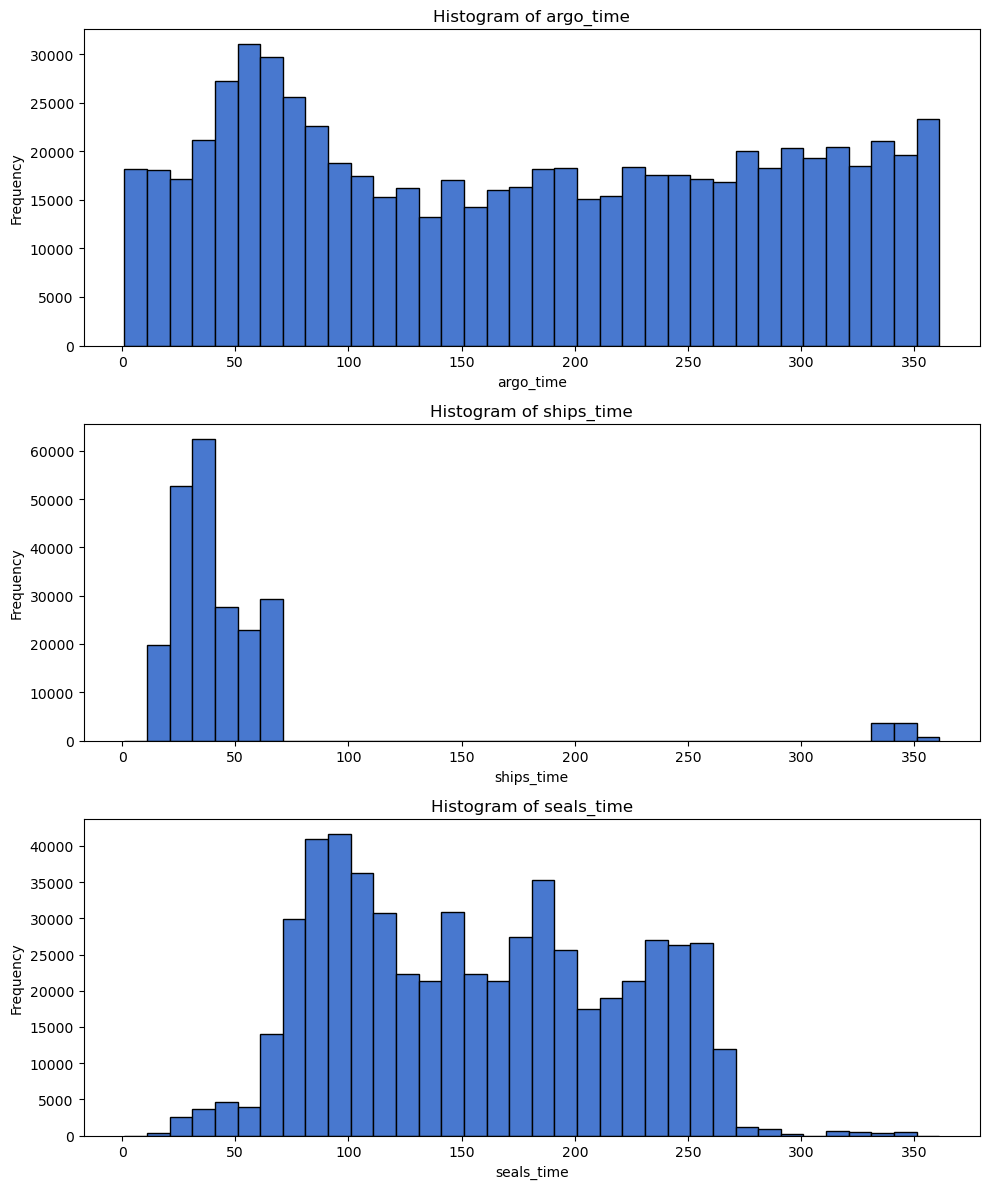

In [11]:
#see what time of year data is in 

# Set bin size
bin_size = 10

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Plot histogram for argo_time
axes[0].hist(argo_time, bins=range(1, 366, bin_size), edgecolor='black')
axes[0].set_title('Histogram of argo_time')
axes[0].set_xlabel('argo_time')
axes[0].set_ylabel('Frequency')

# Plot histogram for ships_time
axes[1].hist(ships_time, bins=range(1, 366, bin_size), edgecolor='black')
axes[1].set_title('Histogram of ships_time')
axes[1].set_xlabel('ships_time')
axes[1].set_ylabel('Frequency')

# Plot histogram for seals_time
axes[2].hist(seals_time, bins=range(1, 366, bin_size), edgecolor='black')
axes[2].set_title('Histogram of seals_time')
axes[2].set_xlabel('seals_time')
axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

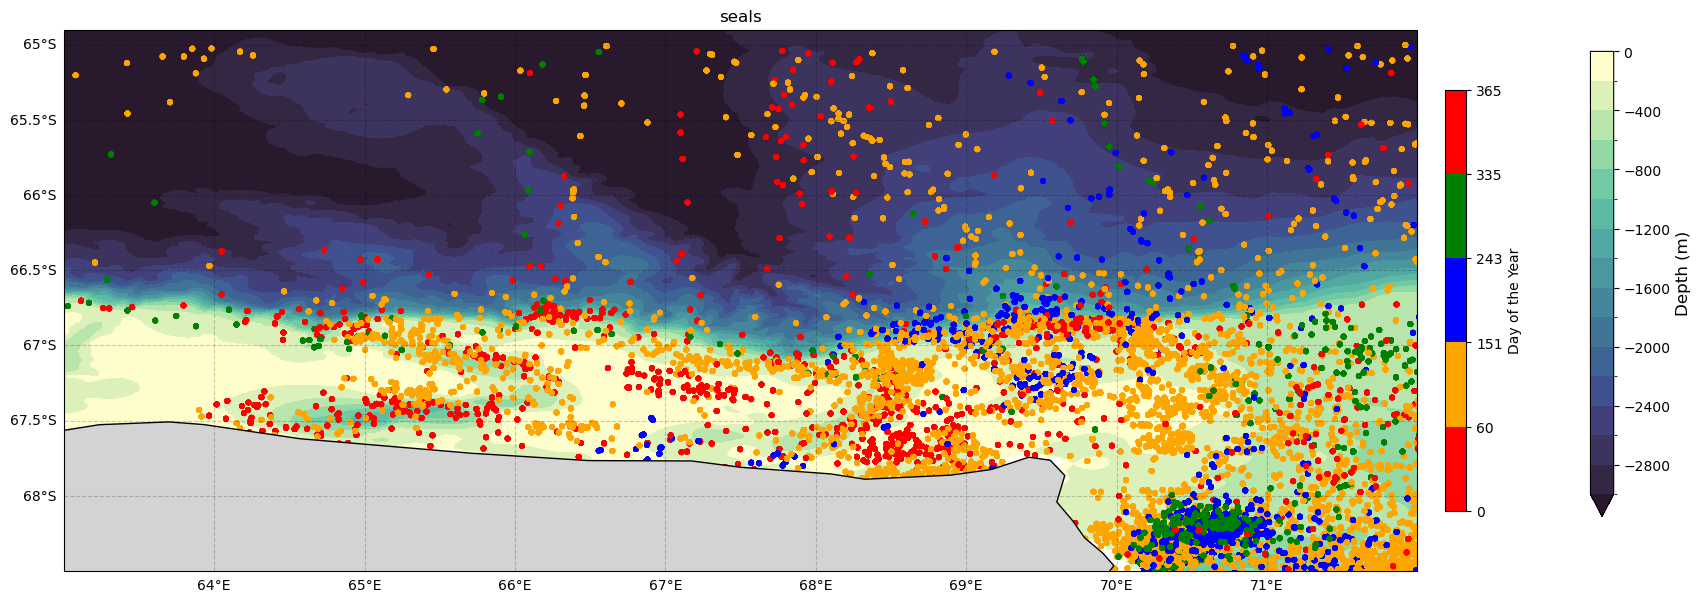

In [12]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,15])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.xlines = True  # Show x-axis grid lines
gl.ylines = True  # Show y-axis grid lines
gl.xlocator = mticker.MultipleLocator(1)  # Set x-axis grid interval to 1 degree
gl.ylocator = mticker.MultipleLocator(0.5)  # Set y-axis grid interval to 0.5 degrees

gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray')
# ax.set_extent([63, 72, -68.5, -63])
ax.set_extent([63, 72, -68.5, -64.9])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.015, pad=0.08)
cbar.set_label('Depth (m)', fontsize=12)


# Plot the contour polygon
# ax.scatter(seals_longitude, seals_latitude, color='red', s=5)


# Define custom colormap
cmap = ListedColormap(['red', 'orange', 'blue', 'green', 'red'])
# Define corresponding bounds for each color
bounds = [0, 60, 151, 243, 335, 365]
# Create a normalization instance and associate it with the colormap
norm = BoundaryNorm(bounds, cmap.N, clip=True)
scatter = ax.scatter(seals_longitude, seals_latitude, c=seals_time, s=10, cmap=cmap, norm=norm)

# Add a colorbar to the plot
cbar2 = plt.colorbar(scatter, ticks=bounds, label='Day of the Year', boundaries=bounds, fraction=0.015, pad=0.02)
# # Set colorbar tick labels
# cbar2.set_ticklabels(['Summer', 'Autumn', 'Winter', 'Spring'])


plt.title('seals')

plt.show()

<Figure size 640x480 with 0 Axes>

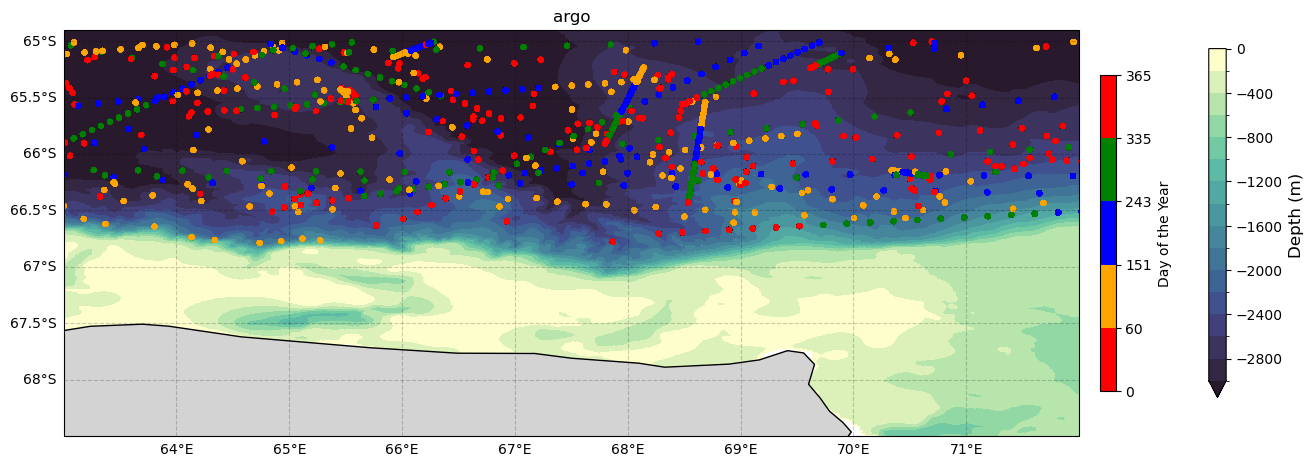

In [85]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.xlines = True  # Show x-axis grid lines
gl.ylines = True  # Show y-axis grid lines
gl.xlocator = mticker.MultipleLocator(1)  # Set x-axis grid interval to 1 degree
gl.ylocator = mticker.MultipleLocator(0.5)  # Set y-axis grid interval to 0.5 degrees

gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
# ax.set_extent([63, 72, -68.5, -63])
ax.set_extent([63, 72, -68.5, -64.9])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.015, pad=0.08)
cbar.set_label('Depth (m)', fontsize=12)



# ax.scatter(argo_longitude, argo_latitude, color='red', s=10)

# Define custom colormap
cmap = ListedColormap(['red', 'orange', 'blue', 'green', 'red'])
# Define corresponding bounds for each color
bounds = [0, 60, 151, 243, 335, 365]
# Create a normalization instance and associate it with the colormap
norm = BoundaryNorm(bounds, cmap.N, clip=True)
scatter = ax.scatter(argo_longitude, argo_latitude, c=argo_time, s=10, cmap=cmap, norm=norm)

# Add a colorbar to the plot
cbar2 = plt.colorbar(scatter, ticks=bounds, label='Day of the Year', boundaries=bounds, fraction=0.015, pad=0.02)
# # Set colorbar tick labels
# cbar2.set_ticklabels(['Summer', 'Autumn', 'Winter', 'Spring'])


plt.title('argo')

plt.show()

<Figure size 640x480 with 0 Axes>

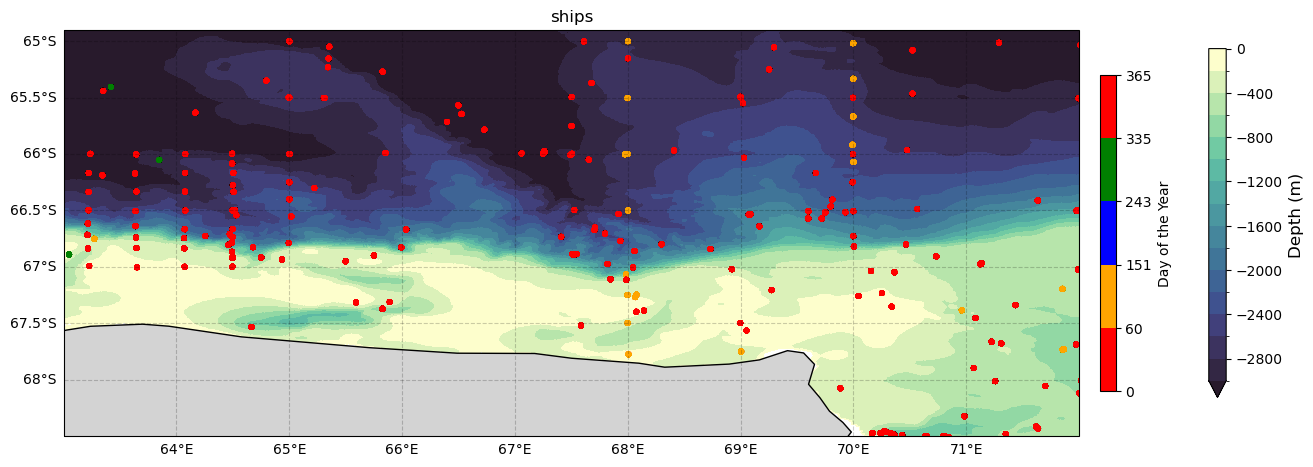

In [86]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.xlines = True  # Show x-axis grid lines
gl.ylines = True  # Show y-axis grid lines
gl.xlocator = mticker.MultipleLocator(1)  # Set x-axis grid interval to 1 degree
gl.ylocator = mticker.MultipleLocator(0.5)  # Set y-axis grid interval to 0.5 degrees

gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
# ax.set_extent([63, 72, -68.5, -63])
ax.set_extent([63, 72, -68.5, -64.9])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)


#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.015, pad=0.08)
cbar.set_label('Depth (m)', fontsize=12)



# Plot the contour polygon
# ax.scatter(ships_longitude, ships_latitude, color='red', s=10)
# sc = ax.scatter(ships_longitude, ships_latitude, c=colors, s=15, cmap=cmap)

# Define custom colormap
cmap = ListedColormap(['red', 'orange', 'blue', 'green', 'red'])
# Define corresponding bounds for each color
bounds = [0, 60, 151, 243, 335, 365]
# Create a normalization instance and associate it with the colormap
norm = BoundaryNorm(bounds, cmap.N, clip=True)
scatter = ax.scatter(ships_longitude, ships_latitude, c=ships_time, s=10, cmap=cmap, norm=norm)

# Add a colorbar to the plot
cbar2 = plt.colorbar(scatter, ticks=bounds, label='Day of the Year', boundaries=bounds, fraction=0.015, pad=0.02)
# # Set colorbar tick labels
# cbar2.set_ticklabels(['Summer', 'Autumn', 'Winter', 'Spring'])


plt.title('ships')

plt.show()

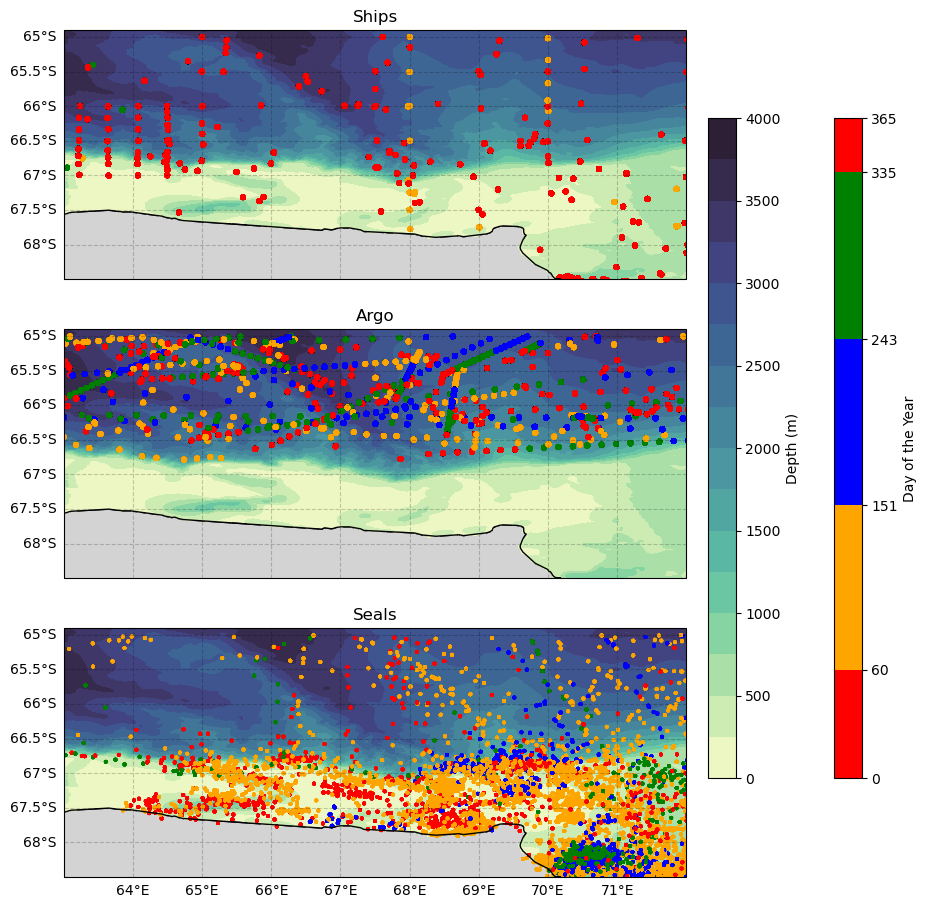

In [90]:
# Assuming 'gebco_full' is your bathymetry data
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)
elevation = -1 * elevation

# Create a figure and define a projection for Cartopy
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 11), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent using the projection's set_extent method
ax1.set_extent([63, 72, -68.5, -64.9])
ax2.set_extent([63, 72, -68.5, -64.9])
ax3.set_extent([63, 72, -68.5, -64.9])


# Other configurations for the axes

# Add gridlines
gl1 = ax1.gridlines(draw_labels=True, color='black', alpha=0.2, linestyle='--')
gl2 = ax2.gridlines(draw_labels=True, color='black', alpha=0.2, linestyle='--')
gl3 = ax3.gridlines(draw_labels=True, color='black', alpha=0.2, linestyle='--')

# Set tick labels
gl1.top_labels = False
gl1.right_labels = False
gl1.bottom_labels = False
gl2.top_labels = False
gl2.right_labels = False
gl2.bottom_labels = False
gl3.top_labels = False
gl3.right_labels = False


gl1.xlocator = mticker.MultipleLocator(1)  # Set x-axis grid interval to 1 degree
gl1.ylocator = mticker.MultipleLocator(0.5)  # Set y-axis grid interval to 0.5 degrees
gl2.xlocator = mticker.MultipleLocator(1)  # Set x-axis grid interval to 1 degree
gl2.ylocator = mticker.MultipleLocator(0.5)  # Set y-axis grid interval to 0.5 degrees
gl3.xlocator = mticker.MultipleLocator(1)  # Set x-axis grid interval to 1 degree
gl3.ylocator = mticker.MultipleLocator(0.5)  # Set y-axis grid interval to 0.5 degrees

# Add coastlines
ax1.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.COASTLINE)

land1 = ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
land2 = ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
land3 = ax3.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')


# Plot elevation data on each subplot
levels = np.arange(0, 4250, 250)
im1 = ax1.contourf(elevation.lon, elevation.lat, elevation, cmap='cmo.deep', levels=levels, add_colorbar=False)
im2 = ax2.contourf(elevation.lon, elevation.lat, elevation, cmap='cmo.deep', levels=levels, add_colorbar=False)
im3 = ax3.contourf(elevation.lon, elevation.lat, elevation, cmap='cmo.deep', levels=levels, add_colorbar=False)



# Define custom colormap
cmap = ListedColormap(['red', 'orange', 'blue', 'green', 'red'])
# Define corresponding bounds for each color
bounds = [0, 60, 151, 243, 335, 365]
# Create a normalization instance and associate it with the colormap
# norm = BoundaryNorm(bounds, cmap.N, clip=True)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

#scatter plots
scatter1 = ax1.scatter(ships_longitude, ships_latitude, c=ships_time, s=10, cmap=cmap, norm=norm)
scatter2 = ax2.scatter(argo_longitude, argo_latitude, c=argo_time, s=10, cmap=cmap, norm=norm)
scatter3 = ax3.scatter(seals_longitude, seals_latitude, c=seals_time, s=3, cmap=cmap, norm=norm)



# First colorbar
cbar_ax1 = fig.add_axes([0.75, 0.2, 0.02, 0.6])
fig.colorbar(im3, cax=cbar_ax1, orientation='vertical', label='Depth (m)', cmap='cmo.deep', extend='min')
# Second colorbar
cbar_ax2 = fig.add_axes([0.84, 0.2, 0.02, 0.6]) 
# fig.colorbar(scatter3, cax=cbar_ax2, ticks=bounds, label='Day of the Year', boundaries=bounds)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cbar_ax2, orientation='vertical', spacing='proportional',
             label='Day of the Year')



ax1.set_title('Ships')  
ax2.set_title('Argo')
ax3.set_title('Seals')

# Show the plot
plt.show()


In [11]:
# Define the range for the transect along __E line

# #autumn
min_time = 60
max_time = 151
# # winter
# min_time = 152
# max_time = 212
# spring
# min_time = 213
# max_time = 334
# #summer
# min_time = 60
# max_time = 335


# Create a boolean mask for points within the specified range
in_range_seals =  ((seals_time >= min_time) & (seals_time <= max_time))
in_range_ships = ((ships_time >= min_time) & (ships_time <= max_time))
in_range_argo = ((argo_time >= min_time) & (argo_time <= max_time))

# this is for summer only 
# in_range_seals =  ((seals_time <= min_time) | (seals_time >= max_time))
# in_range_ships = ((ships_time <= min_time) | (ships_time >= max_time))
# in_range_argo = ((argo_time <= min_time) | (argo_time >= max_time))


<Figure size 640x480 with 0 Axes>

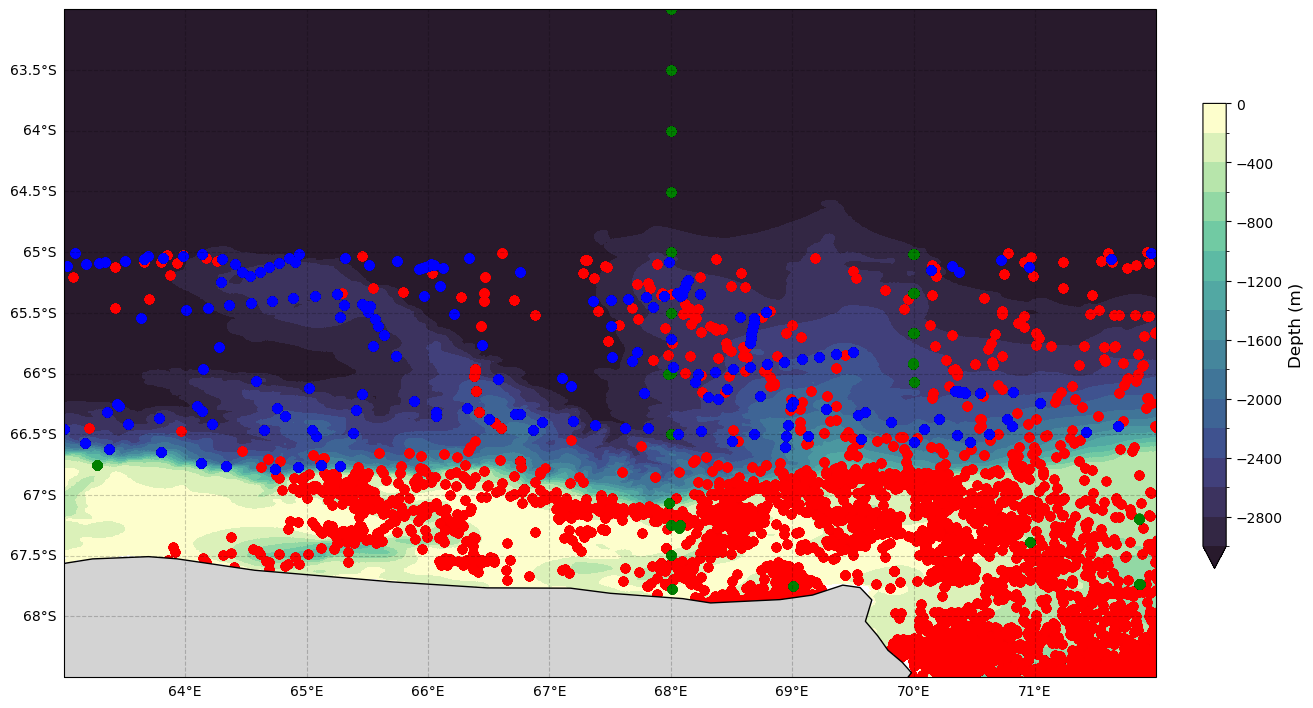

In [138]:
#all data in one season 

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.xlines = True  # Show x-axis grid lines
gl.ylines = True  # Show y-axis grid lines
gl.xlocator = mticker.MultipleLocator(1)  # Set x-axis grid interval to 1 degree
gl.ylocator = mticker.MultipleLocator(0.5)  # Set y-axis grid interval to 0.5 degrees

gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Plot seals data in red
ax.scatter(seals_longitude[in_range_seals], seals_latitude[in_range_seals], color='red', label='Seals')

# Plot ships data in green
ax.scatter(ships_longitude[in_range_ships], ships_latitude[in_range_ships], color='green', label='Ships')

# Plot argo data in blue
ax.scatter(argo_longitude[in_range_argo], argo_latitude[in_range_argo], color='blue', label='Argo')

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

# plt.title('ships')

plt.show()

In [64]:
# Assuming all_lat is already defined as a NumPy array
minimum_latitude = np.min(all_lat)

print("Minimum Latitude:", minimum_latitude)

Minimum Latitude: -67.77583


In [65]:
# Define the range for the transect along __E line

#make sure to align it with whatever ship transect you have chosen 
# #65 lon
# min_longitude = 64.99
# max_longitude = 65.01
# #68
min_longitude = 67.99
max_longitude = 68.01
#70 lon
# min_longitude = 69.99
# max_longitude = 70.01

#set this to the min lat found in this transect calculated above 
max_latitude = minimum_latitude
# for the 68 transect 

#this makes sure that its only using data in summer because the ship transects are in summer 
#everything except winter
min_time = 151
max_time = 213
# #just summer
# min_time = 60
# max_time = 334


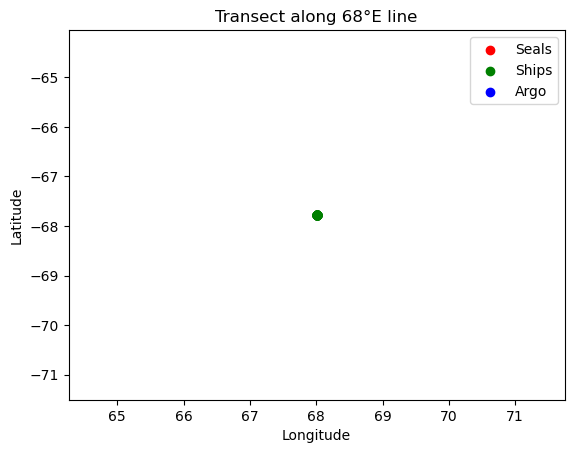

In [66]:
# Create a boolean mask for points within the specified range
in_range_seals = (seals_longitude >= min_longitude) & (seals_longitude <= max_longitude) & (seals_latitude <= max_latitude) & ((seals_time < min_time) | (seals_time > max_time))
in_range_ships = (ships_longitude >= min_longitude) & (ships_longitude <= max_longitude) & (ships_latitude <= max_latitude) & ((ships_time < min_time) | (ships_time > max_time))
in_range_argo = (argo_longitude >= min_longitude) & (argo_longitude <= max_longitude) & (argo_latitude <= max_latitude) & ((argo_time < min_time) | (argo_time > max_time))

# Create a boolean mask for points within the specified range without time range limit
# in_range_seals = (seals_longitude >= min_longitude) & (seals_longitude <= max_longitude) & (seals_latitude <= max_latitude)
# in_range_ships = (ships_longitude >= min_longitude) & (ships_longitude <= max_longitude) & (ships_latitude <= max_latitude)
# in_range_argo = (argo_longitude >= min_longitude) & (argo_longitude <= max_longitude) & (argo_latitude <= max_latitude) 



# Plot seals data in red
plt.scatter(seals_longitude[in_range_seals], seals_latitude[in_range_seals], color='red', label='Seals')

# Plot ships data in green
plt.scatter(ships_longitude[in_range_ships], ships_latitude[in_range_ships], color='green', label='Ships')

# Plot argo data in blue
plt.scatter(argo_longitude[in_range_argo], argo_latitude[in_range_argo], color='blue', label='Argo')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Transect along {longitude_line}°E line')
plt.legend()

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

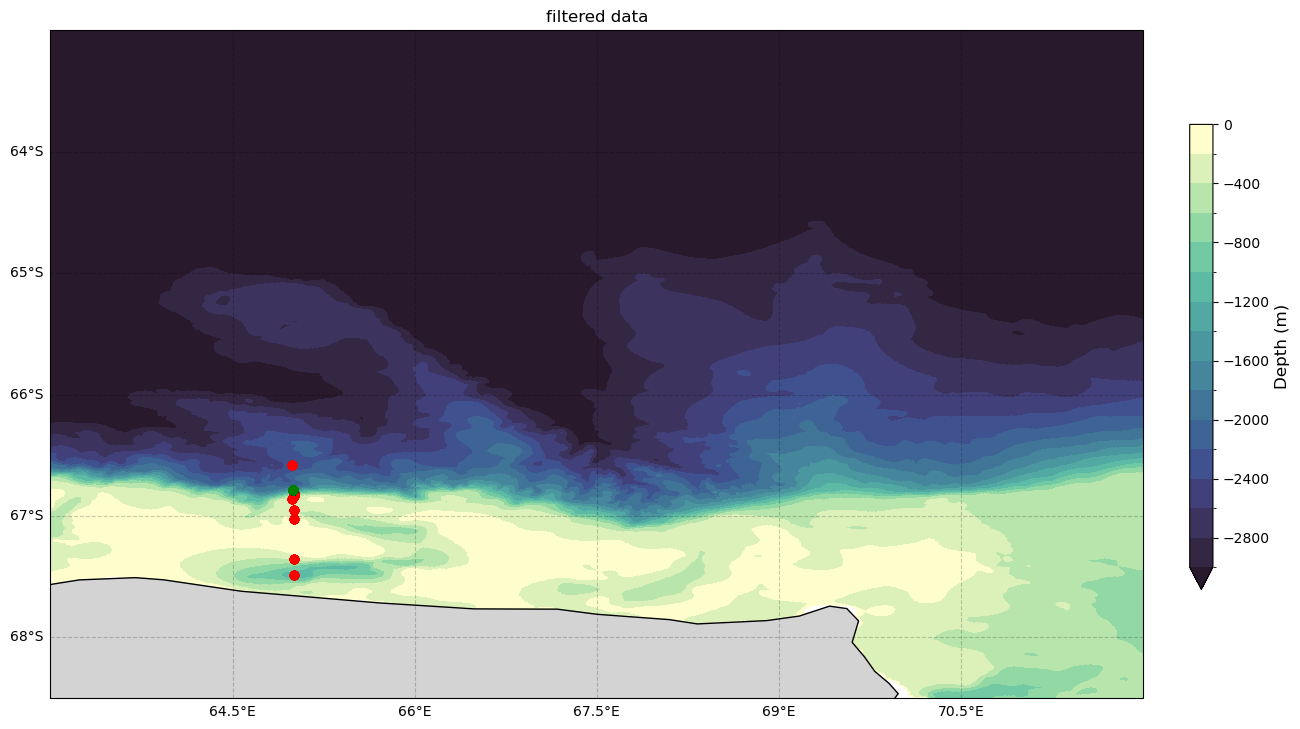

In [50]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Plot seals data in red
plt.scatter(seals_longitude[in_range_seals], seals_latitude[in_range_seals], color='red', label='Seals')

# Plot ships data in green
plt.scatter(ships_longitude[in_range_ships], ships_latitude[in_range_ships], color='green', label='Ships')

# Plot argo data in blue
plt.scatter(argo_longitude[in_range_argo], argo_latitude[in_range_argo], color='blue', label='Argo')

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.title('filtered data')

plt.show()

In [67]:
#extract shelf data

# Extract relevant variables for each data type
seals_data = {
    'latitude': seals_latitude[in_range_seals],
    'longitude': seals_longitude[in_range_seals],
    'depth': seals_depth[in_range_seals],
    'cons_temperature': seals_cons_temperature[in_range_seals],
    'abs_salinity': seals_abs_salinity[in_range_seals],
    'neutral_density': seals_neutral_density[in_range_seals],
    'time': seals_time[in_range_seals]
}

ships_data = {
    'latitude': ships_latitude[in_range_ships],
    'longitude': ships_longitude[in_range_ships],
    'depth': ships_depth[in_range_ships],
    'cons_temperature': ships_cons_temperature[in_range_ships],
    'abs_salinity': ships_abs_salinity[in_range_ships],
    'neutral_density': ships_neutral_density[in_range_ships],
    'time': ships_time[in_range_ships]
}

argo_data = {
    'latitude': argo_latitude[in_range_argo],
    'longitude': argo_longitude[in_range_argo],
    'depth': argo_depth[in_range_argo],
    'cons_temperature': argo_cons_temperature[in_range_argo],
    'abs_salinity': argo_abs_salinity[in_range_argo],
    'neutral_density': argo_neutral_density[in_range_argo],
    'time': argo_time[in_range_argo]
}

# Combine the data into a single dataset
combined_data = {
    'latitude': np.concatenate([seals_data['latitude'], ships_data['latitude'], argo_data['latitude']]),
    'depth': np.concatenate([seals_data['depth'], ships_data['depth'], argo_data['depth']]),
    'cons_temperature': np.concatenate([seals_data['cons_temperature'], ships_data['cons_temperature'], argo_data['cons_temperature']]),
    'abs_salinity': np.concatenate([seals_data['abs_salinity'], ships_data['abs_salinity'], argo_data['abs_salinity']]),
    'neutral_density': np.concatenate([seals_data['neutral_density'], ships_data['neutral_density'], argo_data['neutral_density']]),
    'time': np.concatenate([seals_data['time'], ships_data['time'], argo_data['time']])
}

In [68]:
# combine ship & shelf data

# Create a dictionary with the ship transect data
ship_data = {
    'latitude': all_lat,
    'depth': all_depth,
    'cons_temperature': all_cons_temp,
    'abs_salinity': all_abs_salt,
    'neutral_density': all_neu_dens,
    'time': all_time
}

# Convert the dictionary to a pandas DataFrame
ship_df = pd.DataFrame(ship_data)


# Create a new dictionary with the combined data
combined_data = {
    'latitude': np.concatenate([ship_df['latitude'], combined_data['latitude']]),
    'depth': np.concatenate([ship_df['depth'], combined_data['depth']]),
    'cons_temperature': np.concatenate([ship_df['cons_temperature'], combined_data['cons_temperature']]),
    'abs_salinity': np.concatenate([ship_df['abs_salinity'], combined_data['abs_salinity']]),
    'neutral_density': np.concatenate([ship_df['neutral_density'], combined_data['neutral_density']]),
    'time': np.concatenate([ship_df['time'], combined_data['time']])  # Adjust as needed, assuming time is present in the new data
}

# Convert the combined dictionary to a pandas DataFrame
combined_df = pd.DataFrame(combined_data)

In [69]:
#give the combined data easy variable names
latitude = combined_df['latitude']
depth = combined_df['depth']
cons_temperature = combined_df['cons_temperature']
abs_salinity = combined_df['abs_salinity']
neutral_density = combined_df['neutral_density']
time = combined_df['time']

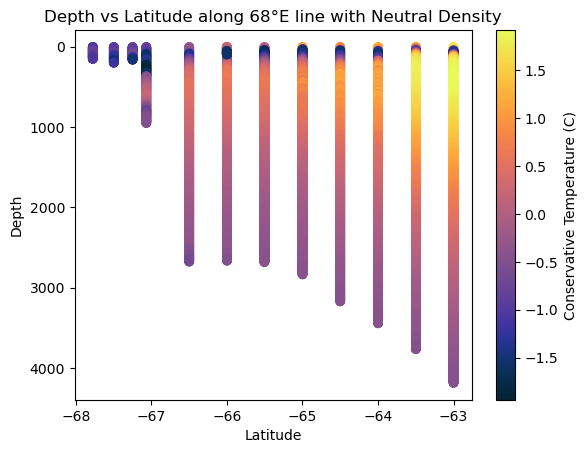

In [19]:
# Plot depth vs latitude along the __E line
# plt.scatter(combined_data['latitude'], combined_data['depth'], c=combined_data['cons_temperature'], cmap='cmo.thermal')
# plt.scatter(ships_data['latitude'], ships_data['depth'], c=ships_data['cons_temperature'], cmap='cmo.thermal')
plt.scatter(latitude, depth, c=cons_temperature, cmap='cmo.thermal')
# Reverse the y-axis to have 0m at the top
plt.gca().invert_yaxis()
plt.colorbar(label='Conservative Temperature (C)')
plt.xlabel('Latitude')
plt.ylabel('Depth')
plt.title(f'Depth vs Latitude along {longitude_line}°E line with Neutral Density')
plt.show()


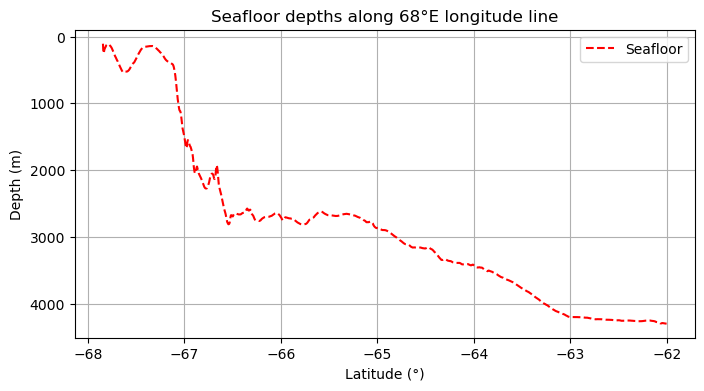

In [70]:
bathymetry_along_transect = gebco_full.sel(lon=longitude_line, method='nearest')


# Extract latitude and depth values
sea_floor_latitude = bathymetry_along_transect['lat'].values
sea_floor_depth = -bathymetry_along_transect['elevation'].values  #negative coz bathymetry 

# Create a boolean mask for depths less than 0
mask = sea_floor_depth > 0

# Apply the mask to both latitude and depth arrays
sea_floor_latitude = sea_floor_latitude[mask]
sea_floor_depth = sea_floor_depth[mask]

sea_floor = np.column_stack((sea_floor_latitude, sea_floor_depth))

# Now, you have the latitude and seafloor depth values along the 68°E longitude line.

# Plot the seafloor depths along the 68°E longitude line
plt.figure(figsize=(8, 4))
plt.plot(sea_floor_latitude, sea_floor_depth, color='red', linestyle='--', label='Seafloor')
plt.xlabel('Latitude (°)')
plt.ylabel('Depth (m)')
plt.title(f'Seafloor depths along {longitude_line}°E longitude line')
plt.legend()
plt.grid()
# Invert the y-axis
plt.gca().invert_yaxis()
plt.show()

-67.84375 -62.00208333333333
108.0 4298.0


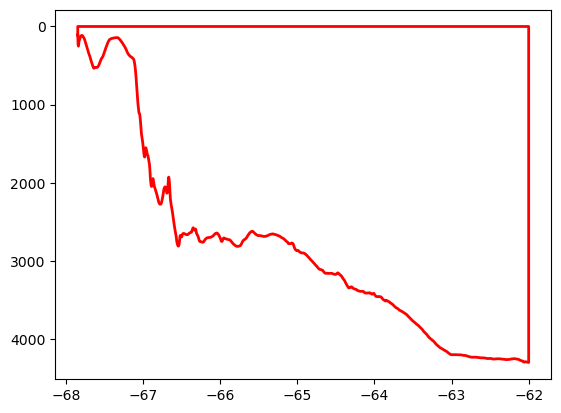

In [71]:
#this creates the polygon with 2 straight lines and the one contour from above

# print(contour_line_coordinates)

# Create the Shapely LineString from the contour points
contour_line = LineString(sea_floor)

# Find the starting and ending coordinates of the contour line
start_lat, start_depth = sea_floor[0]
end_lat, end_depth = sea_floor[-1]

print(start_lat, end_lat)
print(start_depth, end_depth)

# Create the other three sides of the polygon
#below sea floor
# side1 = LineString([(end_lat, end_depth), (start_lat, end_depth)])
# side2 = LineString([(start_lat, end_depth), (start_lat, start_depth)])
#above sea floor
side1 = LineString([(end_lat, end_depth), (end_lat, 0)])
side2 = LineString([(end_lat, 0), (start_lat, 0)])
side3 = LineString([(start_lat, 0), (start_lat, start_depth)])

# # Create an empty Polygon
# polygon_sea_floor = Polygon()

# Create a polygon by passing the combined coordinates to the Polygon constructor
#below sea floor
# polygon_sea_floor = Polygon(list(contour_line.coords) + list(side1.coords) + list(side2.coords))
#above sea floor
polygon_sea_floor = Polygon(list(contour_line.coords) + list(side1.coords) + list(side2.coords) + list(side3.coords))

# output the polygon to series of xy values
x, y = polygon_sea_floor.exterior.xy

plt.plot(x, y, color='red', linewidth=2)
plt.gca().invert_yaxis()


In [20]:
# len(latitude)
len(depth)

50439

In [72]:
# Identify NaN values
nan_mask = np.isnan(latitude) | np.isnan(depth) | np.isnan(cons_temperature) | np.isnan(abs_salinity) | np.isnan(neutral_density)
inf_mask = np.isinf(latitude) | np.isinf(depth) | np.isinf(cons_temperature) | np.isinf(abs_salinity) | np.isinf(neutral_density)


# Remove NaN values from input data
latitude = latitude[~nan_mask & ~inf_mask]
depth = depth[~nan_mask & ~inf_mask]
cons_temperature = cons_temperature[~nan_mask & ~inf_mask]
neutral_density = neutral_density[~nan_mask & ~inf_mask]
abs_salinity = abs_salinity[~nan_mask & ~inf_mask]
time = time[~nan_mask & ~inf_mask]

In [72]:
# len(latitude)
len(depth)

13801

In [73]:
# Reduce grid resolution
grid_points = 300
grid_lon = np.linspace(latitude.min(), latitude.max(), grid_points)
grid_depth = np.linspace(depth.min(), depth.max(), grid_points)
grid_X, grid_Z = np.meshgrid(grid_lon, grid_depth)

In [74]:
# Use smaller data type
dtype = np.float32

# Perform the interpolation using griddata
grid_cons_temp = griddata((latitude, depth), cons_temperature, (grid_X, grid_Z), method='linear').astype(dtype)
grid_neu_dens = griddata((latitude, depth), neutral_density, (grid_X, grid_Z), method='linear').astype(dtype)
grid_abs_salt = griddata((latitude, depth), abs_salinity, (grid_X, grid_Z), method='linear').astype(dtype)

In [75]:
# Create a path from the polygon
polygon_path = mpath.Path(np.array(polygon_sea_floor.exterior.coords))

# Flatten the grid coordinates
flat_grid_X = grid_X.flatten()
flat_grid_Z = grid_Z.flatten()

# Create a mask using the polygon path
inside_polygon_mask = polygon_path.contains_points(np.column_stack((flat_grid_X, flat_grid_Z)))

# Reshape the mask to the shape of the original grid
inside_polygon_mask = inside_polygon_mask.reshape(grid_X.shape)

# Apply the mask to the gridded data
grid_cons_temp_inside_polygon = np.ma.masked_where(~inside_polygon_mask, grid_cons_temp)
grid_neu_dens_inside_polygon = np.ma.masked_where(~inside_polygon_mask, grid_neu_dens)
grid_abs_salt_inside_polygon = np.ma.masked_where(~inside_polygon_mask, grid_abs_salt)


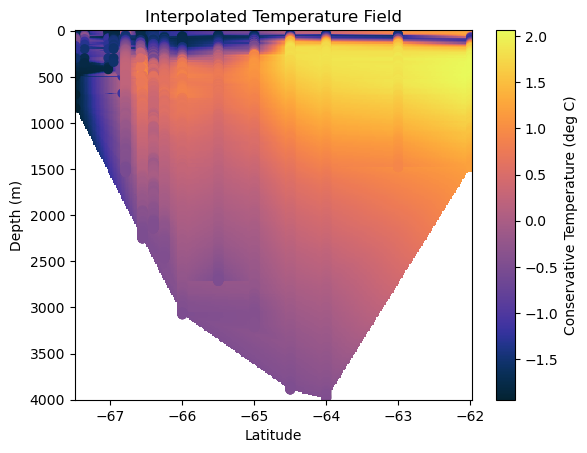

In [45]:
# Plot the interpolated field using pcolormesh
plt.pcolormesh(grid_X, grid_Z, grid_cons_temp, cmap='cmo.thermal')
# plt.pcolormesh(grid_X, grid_Z, grid_cons_temp_inside_polygon, cmap='cmo.thermal')

# Overlay scatter/plot values
# Add vertical dashed white lines for each unique latitude
# for lat in set(latitude):
#     plt.axvline(x=lat, color='white', linestyle='--', linewidth=0.2)
plt.scatter(latitude, depth, c=cons_temperature, cmap='cmo.thermal')
# plt.scatter(latitude, depth, s=1, marker='o', color='w', alpha=0.1)
# plt.plot(latitude, depth, linestyle='dashed', color='white', linewidth=0.5)

# Add colorbar
plt.colorbar(label='Conservative Temperature (deg C)')

# Set labels and title
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.title('Interpolated Temperature Field')

# Reverse the y-axis to have 0m at the top
plt.gca().invert_yaxis()

# Show the plot
plt.show()

In [76]:
#this code is to find the unique lat values so can plot where the actual casts are from 
# Round latitude values to 2 decimal places
rounded_latitudes = [round(lat, 1) for lat in latitude]

# Convert the rounded list to a set to get unique values
unique_latitudes = set(rounded_latitudes)
# print(unique_latitudes)

unique_latitudes_list = list(set(unique_latitudes))
# print(unique_latitudes_list)
# len(unique_latitudes_list)

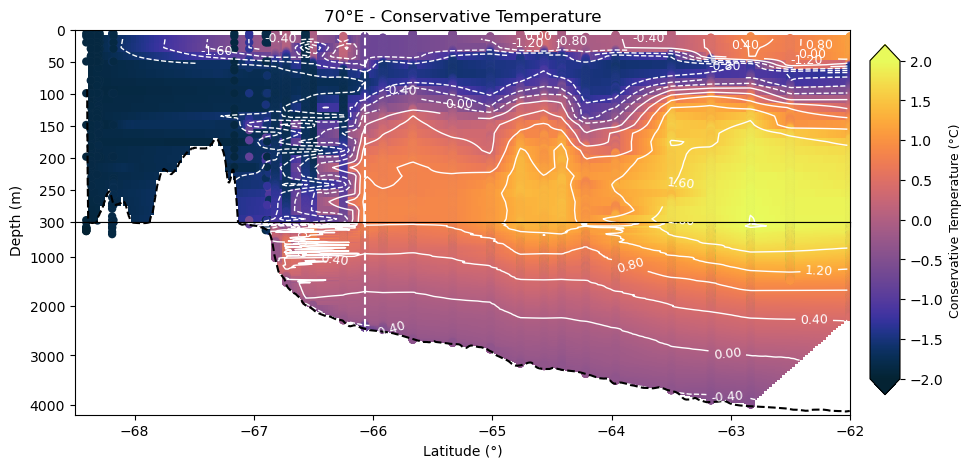

In [121]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)


# First subplot with y-axis range 0-500m
mesh1 = ax1.pcolormesh(grid_X, grid_Z, grid_cons_temp_inside_polygon, cmap='cmo.thermal', vmin=-2, vmax=2)
#cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
#cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
# cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[27.9, 28.27], colors='w', linewidths=1)
cont1 = ax1.contour(grid_X, grid_Z, grid_cons_temp_inside_polygon, levels=10, colors='w', linewidths=1)
# Overlay scatter/plot values
scat1 = ax1.scatter(latitude, depth, c=cons_temperature, cmap='cmo.thermal', edgecolor = 'lightgray', linewidths=0.01, vmin=-2, vmax=2)
# # Add vertical dashed white lines for each unique latitude
# for lat in set(unique_latitudes):
#     ax1.axvline(x=lat, color='white', linestyle='--', linewidth=0.4)
label1 = ax1.clabel(cont1, inline=True, fontsize=9, fmt='%1.2f')
ax1.axvline(x=max_latitude, color='white', linestyle='--', linewidth=1.5)
# Manually adjust the position of the label for the 28-level contour
for label in label1:
    label.set_position((label.get_position()[0], label.get_position()[1] - 20))
ax1.set_ylim(0, 300)
ax1.set_xlim(-68.5, -62)
ax1.set_title(f'{longitude_line}°E - Conservative Temperature')
ax1.invert_yaxis()
ax1.set_xticklabels([])
# ax1.grid(linewidth=0.3, color='lightgray')
# Plot a line for seafloor depths on both subplots
ax1.plot(sea_floor_latitude, sea_floor_depth, color='black', linestyle='--', label='Seafloor')


# Second subplot with y-axis range 500-3500m
mesh2 = ax2.pcolormesh(grid_X, grid_Z, grid_cons_temp_inside_polygon, cmap='cmo.thermal', vmin=-2, vmax=2)
#cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
#cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
# cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[27.9, 28.27], colors='w', linewidths=1)
cont2 = ax2.contour(grid_X, grid_Z, grid_cons_temp_inside_polygon, levels=10, colors='w', linewidths=1)
# Overlay scatter/plot values
scat2 = ax2.scatter(latitude, depth, c=cons_temperature, cmap='cmo.thermal', edgecolor = 'lightgray', linewidths=0.001, vmin=-2, vmax=2)
# # Add vertical dashed white lines for each unique latitude
# for lat in set(unique_latitudes):
#     ax2.axvline(x=lat, color='white', linestyle='--', linewidth=0.4)
ax2.axvline(x=max_latitude, color='white', linestyle='--', linewidth=1.5)
label2 = ax2.clabel(cont2, inline=True, fontsize=9, fmt='%1.2f')
# Get the label for the level 28 contour
label_28 = label2[0]  # Assuming the label for 28 is the first label in the list
# Set the color of the label for level 28 to a different color (e.g., red)
label_28.set_color('gray')
# # Manually adjust the position of the label for the 28-level contour
# for label in label2:
#     label.set_position((label.get_position()[0] + 20, label.get_position()[1]))
ax2.set_ylim(300, 4200)
ax2.set_xlim(-68.5, -62)
ax2.invert_yaxis()
ax2.set_xlabel('Latitude (°)', fontsize=10)
# ax2.grid(linewidth=0.3, color='lightgray')
ax2.plot(sea_floor_latitude, sea_floor_depth, color='black', linestyle='--', label='Seafloor')


# Create a single colorbar for both subplots
cmap = plt.get_cmap('cmo.thermal')
norm = colors.Normalize(vmin=-2, vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  


# Position the colorbar on the right side
cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cax, extend='both')
cbar.set_label('Conservative Temperature (°C)', fontsize=9)
#cbar.set_label('Absolute Salinity (g/kg)', fontsize=9)

# Add y-axis title between the subplots
fig.text(0.06, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Show the plot
plt.show()

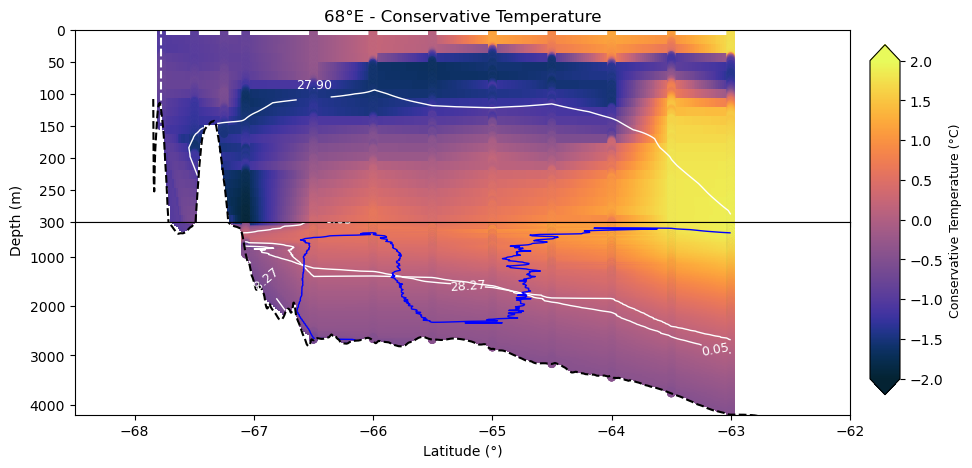

In [79]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)


# First subplot with y-axis range 0-500m
mesh1 = ax1.pcolormesh(grid_X, grid_Z, grid_cons_temp_inside_polygon, cmap='cmo.thermal', vmin=-2, vmax=2)
#cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
#cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[27.9, 28.27], colors='w', linewidths=1)
# Overlay scatter/plot values
scat1 = ax1.scatter(latitude, depth, c=cons_temperature, cmap='cmo.thermal', edgecolor = 'lightgray', linewidths=0.01, vmin=-2, vmax=2)
# # Add vertical dashed white lines for each unique latitude
# for lat in set(unique_latitudes):
#     ax1.axvline(x=lat, color='white', linestyle='--', linewidth=0.4)
label1 = ax1.clabel(cont1, inline=True, fontsize=9, fmt='%1.2f')
ax1.axvline(x=max_latitude, color='white', linestyle='--', linewidth=1.5)
# Manually adjust the position of the label for the 28-level contour
for label in label1:
    label.set_position((label.get_position()[0], label.get_position()[1] - 20))
ax1.set_ylim(0, 300)
ax1.set_xlim(-68.5, -62)
ax1.set_title(f'{longitude_line}°E - Conservative Temperature')
ax1.invert_yaxis()
ax1.set_xticklabels([])
# ax1.grid(linewidth=0.3, color='lightgray')
# Plot a line for seafloor depths on both subplots
ax1.plot(sea_floor_latitude, sea_floor_depth, color='black', linestyle='--', label='Seafloor')


# Second subplot with y-axis range 500-3500m
mesh2 = ax2.pcolormesh(grid_X, grid_Z, grid_cons_temp_inside_polygon, cmap='cmo.thermal', vmin=-2, vmax=2)
#cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
#cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[27.9, 28.27], colors='w', linewidths=1)
cont3 = ax2.contour(grid_X, grid_Z, grid_cons_temp_inside_polygon, levels=[0.05], colors='w', linewidths=1)
cont4 = ax2.contour(grid_X, grid_Z, grid_abs_salt_inside_polygon, levels=[34.85], colors='b', linewidths=1)
# Overlay scatter/plot values
scat2 = ax2.scatter(latitude, depth, c=cons_temperature, cmap='cmo.thermal', edgecolor = 'lightgray', linewidths=0.001, vmin=-2, vmax=2)
# # Add vertical dashed white lines for each unique latitude
# for lat in set(unique_latitudes):
#     ax2.axvline(x=lat, color='white', linestyle='--', linewidth=0.4)
ax2.axvline(x=max_latitude, color='white', linestyle='--', linewidth=1.5)
label2 = ax2.clabel(cont2, inline=True, fontsize=9, fmt='%1.2f')
label3 = ax2.clabel(cont3, inline=True, fontsize=9, fmt='%1.2f')
# Get the label for the level 28 contour
label_28 = label2[0]  # Assuming the label for 28 is the first label in the list
# Set the color of the label for level 28 to a different color (e.g., red)
label_28.set_color('gray')
# # Manually adjust the position of the label for the 28-level contour
# for label in label2:
#     label.set_position((label.get_position()[0] + 20, label.get_position()[1]))
ax2.set_ylim(300, 4200)
ax2.set_xlim(-68.5, -62)
ax2.invert_yaxis()
ax2.set_xlabel('Latitude (°)', fontsize=10)
# ax2.grid(linewidth=0.3, color='lightgray')
ax2.plot(sea_floor_latitude, sea_floor_depth, color='black', linestyle='--', label='Seafloor')


# Create a single colorbar for both subplots
cmap = plt.get_cmap('cmo.thermal')
norm = colors.Normalize(vmin=-2, vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  


# Position the colorbar on the right side
cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cax, extend='both')
cbar.set_label('Conservative Temperature (°C)', fontsize=9)
#cbar.set_label('Absolute Salinity (g/kg)', fontsize=9)

# Add y-axis title between the subplots
fig.text(0.06, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Show the plot
plt.show()

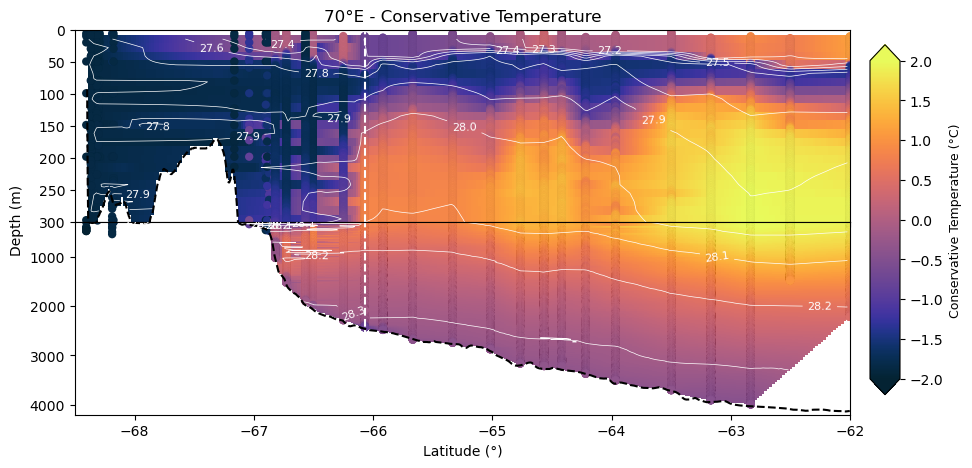

In [26]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)


# First subplot with y-axis range 0-500m
mesh1 = ax1.pcolormesh(grid_X, grid_Z, grid_cons_temp_inside_polygon, cmap='cmo.thermal', vmin=-2, vmax=2)
#cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
# Overlay scatter/plot values
scat1 = ax1.scatter(latitude, depth, c=cons_temperature, cmap='cmo.thermal', edgecolor = 'k', linewidths=0.01, vmin=-2, vmax=2)
# # Add vertical dashed white lines for each cast (with a unique latitude)
# for lat in set(unique_latitudes):
#     ax1.axvline(x=lat, color='white', linestyle='--', linewidth=0.4)
ax1.axvline(x=max_latitude, color='white', linestyle='--', linewidth=1.5)
ax1.clabel(cont1, inline=True, fontsize=8, fmt='%1.1f')
ax1.set_ylim(0, 300)
ax1.set_xlim(-68.5, -62)
ax1.set_title(f'{longitude_line}°E - Conservative Temperature')
ax1.invert_yaxis()
ax1.set_xticklabels([])
# ax1.grid(linewidth=0.3, color='gray')
# Plot a line for seafloor depths on both subplots
ax1.plot(sea_floor_latitude, sea_floor_depth, color='black', linestyle='--', label='Seafloor')


# Second subplot with y-axis range 500-3500m
mesh2 = ax2.pcolormesh(grid_X, grid_Z, grid_cons_temp_inside_polygon, cmap='cmo.thermal', vmin=-2, vmax=2)
#cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
# Overlay scatter/plot values
scat2 = ax2.scatter(latitude, depth, c=cons_temperature, cmap='cmo.thermal', edgecolor = 'k', linewidths=0.001, vmin=-2, vmax=2)
# # Add vertical dashed white lines for each unique latitude
# for lat in set(unique_latitudes):
#     ax2.axvline(x=lat, color='white', linestyle='--', linewidth=0.4)
ax2.axvline(x=max_latitude, color='white', linestyle='--', linewidth=1.5)
ax2.clabel(cont2, inline=True, fontsize=8, fmt='%1.1f')
ax2.set_ylim(300, 4200)
ax2.set_xlim(-68.5, -62)
ax2.invert_yaxis()
ax2.set_xlabel('Latitude (°)', fontsize=10)
# ax2.grid(linewidth=0.3, color='gray')
ax2.plot(sea_floor_latitude, sea_floor_depth, color='black', linestyle='--', label='Seafloor')


# Create a single colorbar for both subplots
cmap = plt.get_cmap('cmo.thermal')
norm = colors.Normalize(vmin=-2, vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  



# Position the colorbar on the right side
cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cax, extend='both')
cbar.set_label('Conservative Temperature (°C)', fontsize=9)
#cbar.set_label('Absolute Salinity (g/kg)', fontsize=9)

# Add y-axis title between the subplots
fig.text(0.06, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Show the plot
plt.show()

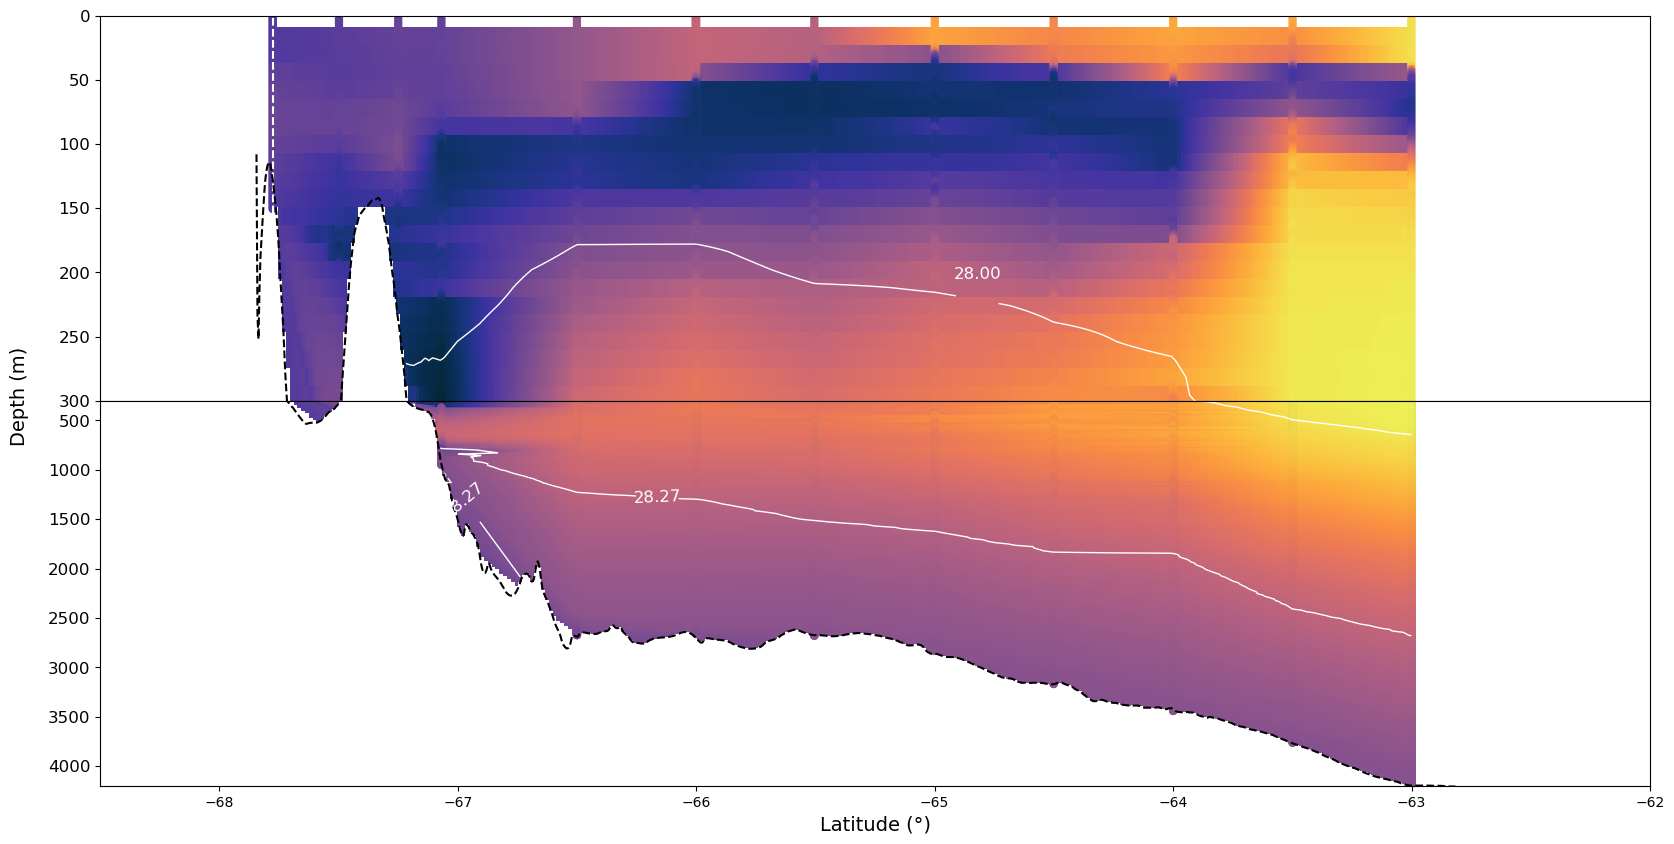

In [28]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)


# First subplot with y-axis range 0-500m
mesh1 = ax1.pcolormesh(grid_X, grid_Z, grid_cons_temp_inside_polygon, cmap='cmo.thermal', vmin=-2, vmax=2)
#cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
#cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[28, 28.27], colors='w', linewidths=1)
# Overlay scatter/plot values
scat1 = ax1.scatter(latitude, depth, c=cons_temperature, cmap='cmo.thermal', edgecolor = 'lightgray', linewidths=0.01, vmin=-2, vmax=2)
# # Add vertical dashed white lines for each unique latitude
# for lat in set(unique_latitudes):
#     ax1.axvline(x=lat, color='white', linestyle='--', linewidth=0.4)
label1 = ax1.clabel(cont1, inline=True, fontsize=12, fmt='%1.2f')
ax1.axvline(x=max_latitude, color='white', linestyle='--', linewidth=1.5)
# Manually adjust the position of the label for the 28-level contour
for label in label1:
    label.set_position((label.get_position()[0], label.get_position()[1] - 20))
ax1.set_ylim(0, 300)
ax1.set_xlim(-68.5, -62)
# ax1.set_title(f'{longitude_line}°E - Conservative Temperature')
ax1.invert_yaxis()
ax1.set_xticklabels([])
# ax1.grid(linewidth=0.3, color='lightgray')
# Plot a line for seafloor depths on both subplots
ax1.plot(sea_floor_latitude, sea_floor_depth, color='black', linestyle='--', label='Seafloor')


# Second subplot with y-axis range 500-3500m
mesh2 = ax2.pcolormesh(grid_X, grid_Z, grid_cons_temp_inside_polygon, cmap='cmo.thermal', vmin=-2, vmax=2)
#cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
#cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[28, 28.27], colors='w', linewidths=1)
# Overlay scatter/plot values
scat2 = ax2.scatter(latitude, depth, c=cons_temperature, cmap='cmo.thermal', edgecolor = 'lightgray', linewidths=0.001, vmin=-2, vmax=2)
# # Add vertical dashed white lines for each unique latitude
# for lat in set(unique_latitudes):
#     ax2.axvline(x=lat, color='white', linestyle='--', linewidth=0.4)
ax2.axvline(x=max_latitude, color='white', linestyle='--', linewidth=1.5)
label2 = ax2.clabel(cont2, inline=True, fontsize=12, fmt='%1.2f')
# Get the label for the level 28 contour
label_28 = label2[0]  # Assuming the label for 28 is the first label in the list
# Set the color of the label for level 28 to a different color (e.g., red)
label_28.set_color('gray')
# # Manually adjust the position of the label for the 28-level contour
# for label in label2:
#     label.set_position((label.get_position()[0] + 20, label.get_position()[1]))
ax2.set_ylim(300, 4200)
ax2.set_xlim(-68.5, -62)
ax2.invert_yaxis()
ax2.set_xlabel('Latitude (°)', fontsize=14)
# ax2.set_xticklabels([])
# ax2.grid(linewidth=0.3, color='lightgray')
ax2.plot(sea_floor_latitude, sea_floor_depth, color='black', linestyle='--', label='Seafloor')


# Increase y-axis tick label font size for both subplots
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)




# # Create a single colorbar for both subplots
# cmap = plt.get_cmap('cmo.thermal')
# norm = colors.Normalize(vmin=-2, vmax=2)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  


# # Position the colorbar on the right side
# cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
# cbar = fig.colorbar(sm, cax=cax, extend='both')
# cbar.set_label('Conservative Temperature (°C)', fontsize=13)
# cbar.ax.tick_params(axis='y', labelsize=11)
# #cbar.set_label('Absolute Salinity (g/kg)', fontsize=9)

# Add y-axis title between the subplots
fig.text(0.08, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=14)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)


# ax1.grid(True)
# ax2.grid(True)

# Show the plot
plt.show()

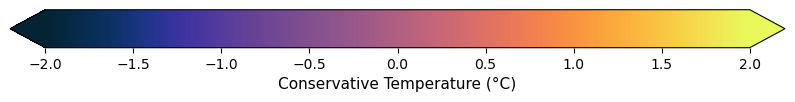

In [44]:
fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

# Create a single colorbar for both subplots
cmap = plt.get_cmap('cmo.thermal')
norm = colors.Normalize(vmin=-2, vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Position the colorbar below the subplot
# cax = fig.add_axes([0.1, 0.4, 0.8, 0.2])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=ax, orientation='horizontal', extend='both')
cbar.set_label('Conservative Temperature (°C)', fontsize=11)

plt.show()

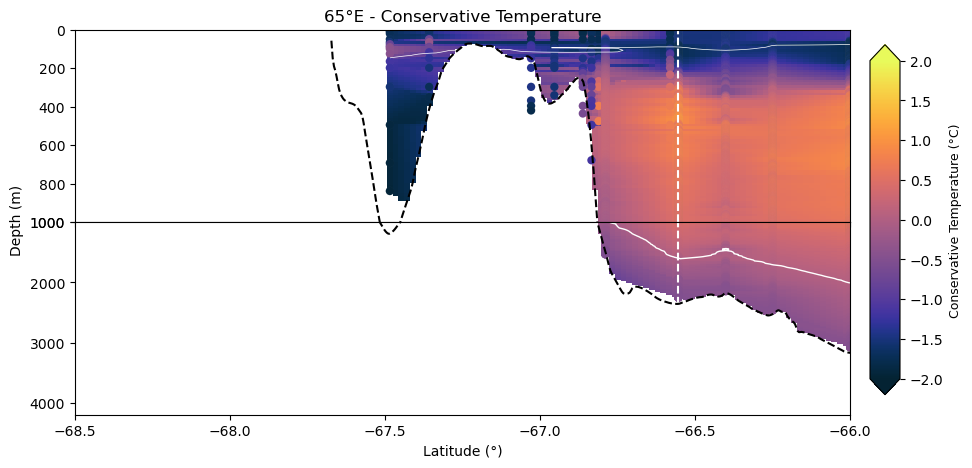

In [46]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)


# First subplot with y-axis range 0-500m
mesh1 = ax1.pcolormesh(grid_X, grid_Z, grid_cons_temp_inside_polygon, cmap='cmo.thermal', vmin=-2, vmax=2)
#cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
# cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.8], colors='w', linewidths=0.5)
# cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[28, 28.27], colors='w', linewidths=1)
# Overlay scatter/plot values
scat1 = ax1.scatter(latitude, depth, c=cons_temperature, cmap='cmo.thermal', edgecolor = 'lightgray', linewidths=0.01, vmin=-2, vmax=2)
# # Add vertical dashed white lines for each unique latitude
# for lat in set(unique_latitudes):
#     ax1.axvline(x=lat, color='white', linestyle='--', linewidth=0.4)
label1 = ax1.clabel(cont1, inline=True, fontsize=9, fmt='%1.2f')
ax1.axvline(x=max_latitude, color='white', linestyle='--', linewidth=1.5)
# Manually adjust the position of the label for the 28-level contour
for label in label1:
    label.set_position((label.get_position()[0], label.get_position()[1] - 20))
ax1.set_ylim(0, 1000)
ax1.set_xlim(-68.5, -66)
ax1.set_title(f'{longitude_line}°E - Conservative Temperature')
ax1.invert_yaxis()
ax1.set_xticklabels([])
# ax1.grid(linewidth=0.3, color='lightgray')
# Plot a line for seafloor depths on both subplots
ax1.plot(sea_floor_latitude, sea_floor_depth, color='black', linestyle='--', label='Seafloor')


# Second subplot with y-axis range 500-3500m
mesh2 = ax2.pcolormesh(grid_X, grid_Z, grid_cons_temp_inside_polygon, cmap='cmo.thermal', vmin=-2, vmax=2)
#cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
#cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[28, 28.27], colors='w', linewidths=1)
# Overlay scatter/plot values
scat2 = ax2.scatter(latitude, depth, c=cons_temperature, cmap='cmo.thermal', edgecolor = 'lightgray', linewidths=0.001, vmin=-2, vmax=2)
# # Add vertical dashed white lines for each unique latitude
# for lat in set(unique_latitudes):
#     ax2.axvline(x=lat, color='white', linestyle='--', linewidth=0.4)
ax2.axvline(x=max_latitude, color='white', linestyle='--', linewidth=1.5)
label2 = ax2.clabel(cont2, inline=True, fontsize=9, fmt='%1.2f')
# Get the label for the level 28 contour
label_28 = label2[0]  # Assuming the label for 28 is the first label in the list
# Set the color of the label for level 28 to a different color (e.g., red)
label_28.set_color('gray')
# # Manually adjust the position of the label for the 28-level contour
# for label in label2:
#     label.set_position((label.get_position()[0] + 20, label.get_position()[1]))
ax2.set_ylim(1000, 4200)
ax2.set_xlim(-68.5, -66)
ax2.invert_yaxis()
ax2.set_xlabel('Latitude (°)', fontsize=10)
# ax2.grid(linewidth=0.3, color='lightgray')
ax2.plot(sea_floor_latitude, sea_floor_depth, color='black', linestyle='--', label='Seafloor')


# Create a single colorbar for both subplots
cmap = plt.get_cmap('cmo.thermal')
norm = colors.Normalize(vmin=-2, vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  


# Position the colorbar on the right side
cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cax, extend='both')
cbar.set_label('Conservative Temperature (°C)', fontsize=9)
#cbar.set_label('Absolute Salinity (g/kg)', fontsize=9)

# Add y-axis title between the subplots
fig.text(0.06, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Show the plot
plt.show()

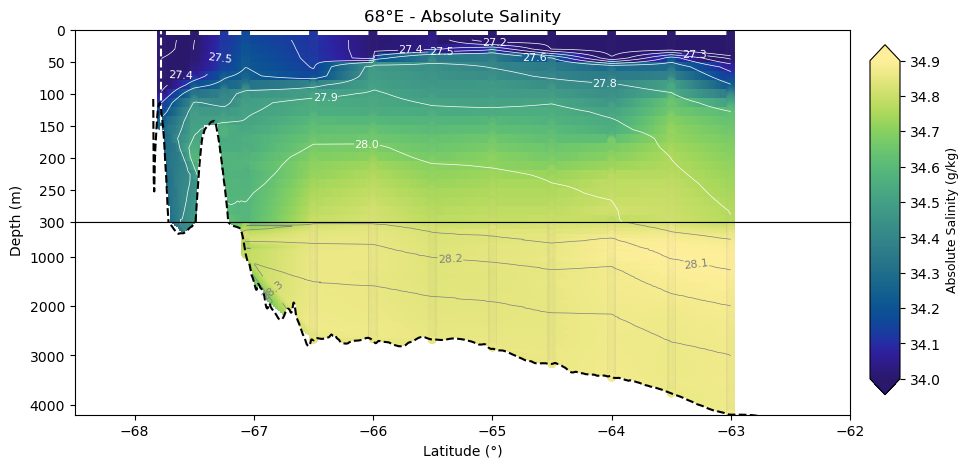

In [26]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)


# First subplot with y-axis range 0-500m
mesh1 = ax1.pcolormesh(grid_X, grid_Z, grid_abs_salt_inside_polygon, cmap='cmo.haline', vmin=34, vmax=34.9)
#cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
# Overlay scatter/plot values
scat1 = ax1.scatter(latitude, depth, c=abs_salinity, cmap='cmo.haline', edgecolor = 'lightgray', linewidths=0.01, vmin=34, vmax=34.9)
# # Add vertical dashed white lines for each unique latitude
# for lat in set(unique_latitudes):
#     ax1.axvline(x=lat, color='white', linestyle='--', linewidth=0.4)
ax1.axvline(x=max_latitude, color='white', linestyle='--', linewidth=1.5)
ax1.clabel(cont1, inline=True, fontsize=8, fmt='%1.1f')
ax1.set_ylim(0, 300)
ax1.set_xlim(-68.5, -62)
ax1.set_title(f'{longitude_line}°E - Absolute Salinity')
ax1.invert_yaxis()
ax1.set_xticklabels([])
# ax1.grid(linewidth=0.3, color='gray')
# Plot a line for seafloor depths on both subplots
ax1.plot(sea_floor_latitude, sea_floor_depth, color='black', linestyle='--', label='Seafloor')


# Second subplot with y-axis range 500-3500m
mesh2 = ax2.pcolormesh(grid_X, grid_Z, grid_abs_salt_inside_polygon, cmap='cmo.haline', vmin=34, vmax=34.9)
#cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='gray', linewidths=0.5)
# Overlay scatter/plot values
scat2 = ax2.scatter(latitude, depth, c=abs_salinity, cmap='cmo.haline', edgecolor = 'lightgray', linewidths=0.001, vmin=34, vmax=34.9)
# # Add vertical dashed white lines for each unique latitude
# for lat in set(unique_latitudes):
#     ax2.axvline(x=lat, color='white', linestyle='--', linewidth=0.4)
ax2.axvline(x=max_latitude, color='white', linestyle='--', linewidth=1.5)
ax2.clabel(cont2, inline=True, fontsize=8, fmt='%1.1f')
ax2.set_ylim(300, 4200)
ax2.set_xlim(-68.5, -62)
ax2.invert_yaxis()
ax2.set_xlabel('Latitude (°)', fontsize=10)
# ax2.grid(linewidth=0.3, color='gray')
ax2.plot(sea_floor_latitude, sea_floor_depth, color='black', linestyle='--', label='Seafloor')


# Create a single colorbar for both subplots
cmap = plt.get_cmap('cmo.haline')
norm = colors.Normalize(vmin=34, vmax=34.9)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  



# Position the colorbar on the right side
cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cax, extend='both')
cbar.set_label('Absolute Salinity (g/kg)', fontsize=9)
#cbar.set_label('Absolute Salinity (g/kg)', fontsize=9)

# Add y-axis title between the subplots
fig.text(0.06, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Show the plot
plt.show()

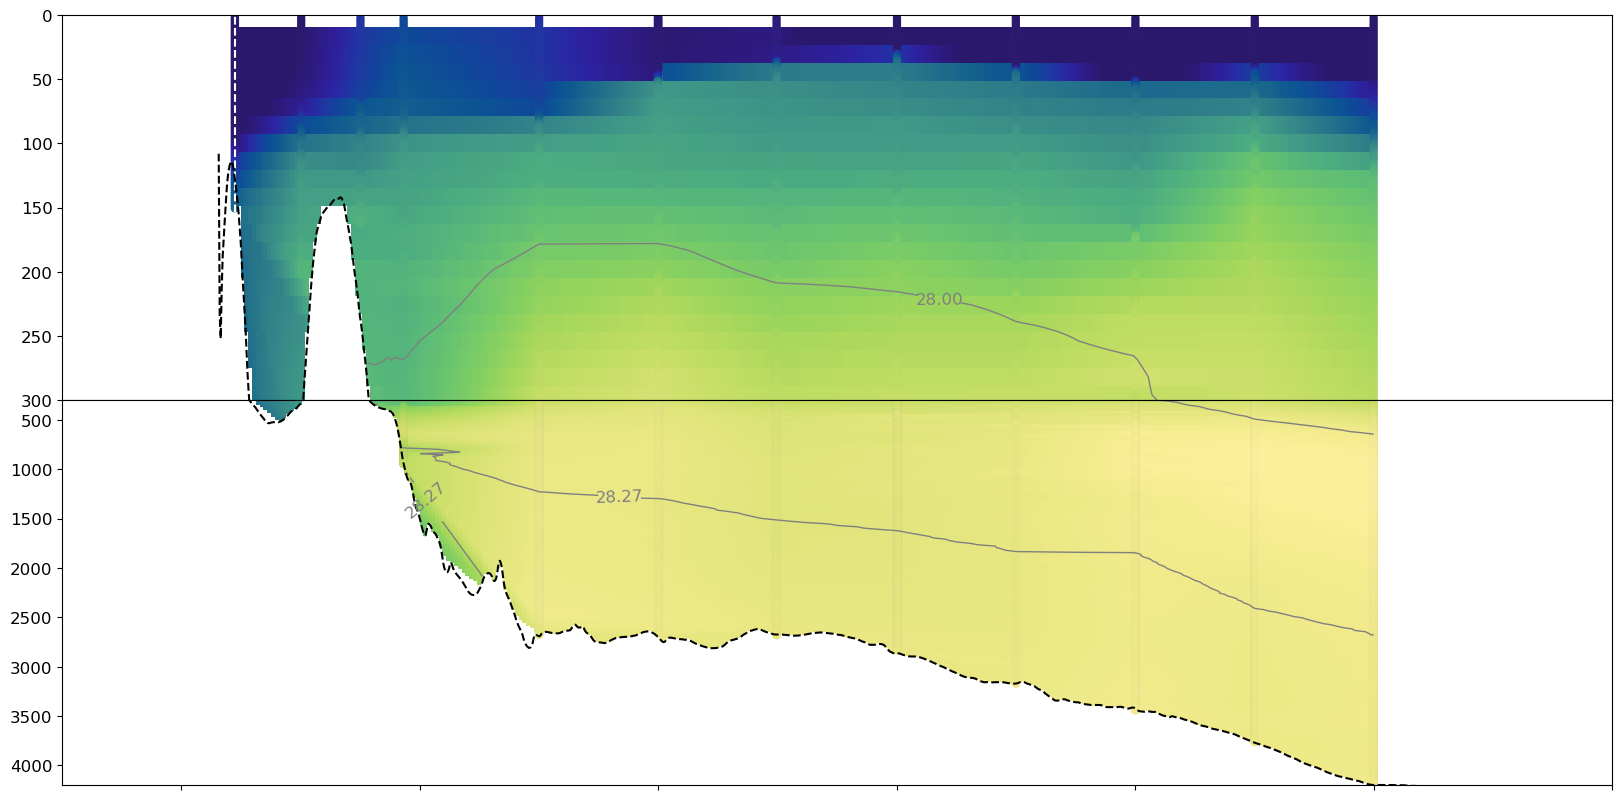

In [77]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)


# First subplot with y-axis range 0-500m
mesh1 = ax1.pcolormesh(grid_X, grid_Z, grid_abs_salt_inside_polygon, cmap='cmo.haline', vmin=34, vmax=34.9)
#cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
# cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[28, 28.27], colors='gray', linewidths=1)
# Overlay scatter/plot values
scat1 = ax1.scatter(latitude, depth, c=abs_salinity, cmap='cmo.haline', edgecolor = 'lightgray', linewidths=0.01, vmin=34, vmax=34.9)
# # Add vertical dashed white lines for each unique latitude
# for lat in set(unique_latitudes):
#     ax1.axvline(x=lat, comax_latitudelor='white', linestyle='--', linewidth=0.4)
ax1.axvline(x=minimum_latitude, color='white', linestyle='--', linewidth=1.5)
ax1.clabel(cont1, inline=True, fontsize=12, fmt='%1.2f')
ax1.set_ylim(0, 300)
ax1.set_xlim(-68.5, -62)
# ax1.set_title(f'{longitude_line}°E - Absolute Salinity')
ax1.invert_yaxis()
ax1.set_xticklabels([])
# ax1.grid(linewidth=0.3, color='gray')
# Plot a line for seafloor depths on both subplots
ax1.plot(sea_floor_latitude, sea_floor_depth, color='black', linestyle='--', label='Seafloor')


# Second subplot with y-axis range 500-3500m
mesh2 = ax2.pcolormesh(grid_X, grid_Z, grid_abs_salt_inside_polygon, cmap='cmo.haline', vmin=34, vmax=34.9)
#cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
# cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='gray', linewidths=0.5)
cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[28, 28.27], colors='gray', linewidths=1)
# Overlay scatter/plot values
scat2 = ax2.scatter(latitude, depth, c=abs_salinity, cmap='cmo.haline', edgecolor = 'lightgray', linewidths=0.001, vmin=34, vmax=34.9)
# # Add vertical dashed white lines for each unique latitude
# for lat in set(unique_latitudes):
#     ax2.axvline(x=lat, color='white', linestyle='--', linewidth=0.4)
ax2.axvline(x=max_latitude, color='white', linestyle='--', linewidth=1.5)
ax2.clabel(cont2, inline=True, fontsize=12, fmt='%1.2f')
ax2.set_ylim(300, 4200)
ax2.set_xlim(-68.5, -62)
ax2.invert_yaxis()
# ax2.set_xlabel('Latitude (°)', fontsize=14)
# ax2.grid(linewidth=0.3, color='gray')
ax2.plot(sea_floor_latitude, sea_floor_depth, color='black', linestyle='--', label='Seafloor')

ax2.set_xticklabels([])

# Increase y-axis tick label font size for both subplots
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)


# # Create a single colorbar for both subplots
# cmap = plt.get_cmap('cmo.haline')
# norm = colors.Normalize(vmin=34, vmax=34.9)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  

# # Position the colorbar on the right side
# cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
# cbar = fig.colorbar(sm, cax=cax, extend='both')
# cbar.set_label('Absolute Salinity (g/kg)', fontsize=9)

# Add y-axis title between the subplots
# fig.text(0.08, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=14)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# ax1.grid(True)
# ax2.grid(True)

# Show the plot
plt.show()

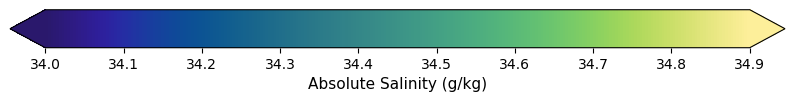

In [51]:
fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

# Create a single colorbar for both subplots
cmap = plt.get_cmap('cmo.haline')
norm = colors.Normalize(vmin=34, vmax=34.9)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  



# Position the colorbar on the right side
# cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=ax, orientation='horizontal', extend='both')
cbar.set_label('Absolute Salinity (g/kg)', fontsize=11)

plt.show()

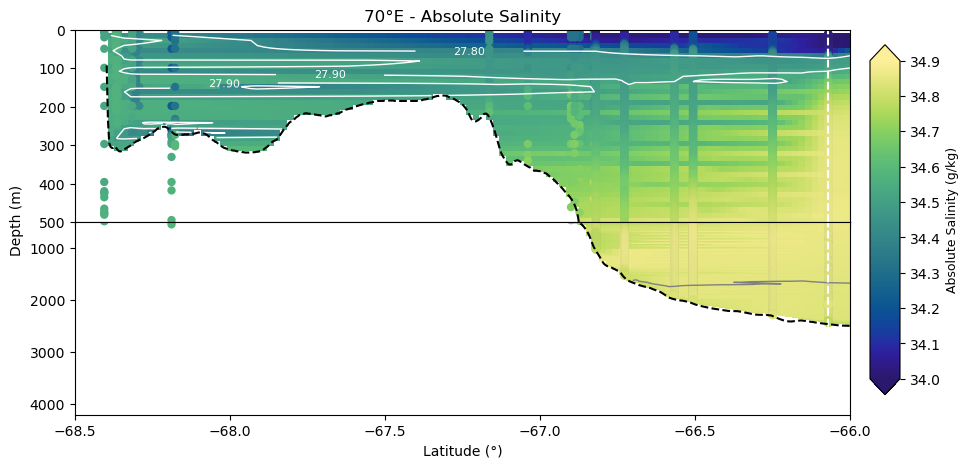

In [216]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)


# First subplot with y-axis range 0-500m
mesh1 = ax1.pcolormesh(grid_X, grid_Z, grid_abs_salt_inside_polygon, cmap='cmo.haline', vmin=34, vmax=34.9)
#cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
# cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='w', linewidths=0.5)
# cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[28, 28.27], colors='gray', linewidths=1)
cont1 = ax1.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[27.8, 27.9], colors='white', linewidths=1)
# Overlay scatter/plot values
scat1 = ax1.scatter(latitude, depth, c=abs_salinity, cmap='cmo.haline', edgecolor = 'lightgray', linewidths=0.01, vmin=34, vmax=34.9)
# # Add vertical dashed white lines for each unique latitude
# for lat in set(unique_latitudes):
#     ax1.axvline(x=lat, comax_latitudelor='white', linestyle='--', linewidth=0.4)
ax1.axvline(x=minimum_latitude, color='white', linestyle='--', linewidth=1.5)
ax1.clabel(cont1, inline=True, fontsize=8, fmt='%1.2f')
ax1.set_ylim(0, 500)
ax1.set_xlim(-68.5, -66)
ax1.set_title(f'{longitude_line}°E - Absolute Salinity')
ax1.invert_yaxis()
ax1.set_xticklabels([])
# ax1.grid(linewidth=0.3, color='gray')
# Plot a line for seafloor depths on both subplots
ax1.plot(sea_floor_latitude, sea_floor_depth, color='black', linestyle='--', label='Seafloor')


# Second subplot with y-axis range 500-3500m
mesh2 = ax2.pcolormesh(grid_X, grid_Z, grid_abs_salt_inside_polygon, cmap='cmo.haline', vmin=34, vmax=34.9)
#cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens, levels=10, colors='w', linewidths=0.5)
# cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3], colors='gray', linewidths=0.5)
cont2 = ax2.contour(grid_X, grid_Z, grid_neu_dens_inside_polygon, levels=[28, 28.27], colors='gray', linewidths=1)
# Overlay scatter/plot values
scat2 = ax2.scatter(latitude, depth, c=abs_salinity, cmap='cmo.haline', edgecolor = 'lightgray', linewidths=0.001, vmin=34, vmax=34.9)
# # Add vertical dashed white lines for each unique latitude
# for lat in set(unique_latitudes):
#     ax2.axvline(x=lat, color='white', linestyle='--', linewidth=0.4)
ax2.axvline(x=max_latitude, color='white', linestyle='--', linewidth=1.5)
ax2.clabel(cont2, inline=True, fontsize=8, fmt='%1.2f')
ax2.set_ylim(500, 4200)
ax2.set_xlim(-68.5, -66)
ax2.invert_yaxis()
ax2.set_xlabel('Latitude (°)', fontsize=10)
# ax2.grid(linewidth=0.3, color='gray')
ax2.plot(sea_floor_latitude, sea_floor_depth, color='black', linestyle='--', label='Seafloor')


# Create a single colorbar for both subplots
cmap = plt.get_cmap('cmo.haline')
norm = colors.Normalize(vmin=34, vmax=34.9)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  



# Position the colorbar on the right side
cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cax, extend='both')
cbar.set_label('Absolute Salinity (g/kg)', fontsize=9)
#cbar.set_label('Absolute Salinity (g/kg)', fontsize=9)

# Add y-axis title between the subplots
fig.text(0.06, 0.5, 'Depth (m)', va='center', rotation='vertical', fontsize=10)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0)

# Show the plot
plt.show()